<center><h1>Shah_Shrey_HW6</h1></center>

Name: Shrey Shah<br>Github Username: shreyshah97<br>USC ID: 5061063668 

## 1. Tree-Based Methods

Import packages

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import sklearn.metrics as metrics
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

### (a) Download the APS Failure data

In [99]:
file_train = '../data/aps_failure_training_set.csv'
file_test = '../data/aps_failure_test_set.csv'

df_train = pd.read_csv(file_train, skiprows=20, na_values = 'na')
df_test = pd.read_csv(file_test, skiprows=20, na_values = 'na')
df_train = df_train.replace({'neg': 0, 'pos': 1, 'na':np.nan})
df_test = df_test.replace({'neg': 0, 'pos': 1, 'na':np.nan})
print("Training Data: ", df_train.shape)
print("Testing Data: ", df_test.shape)

Training Data:  (60000, 171)
Testing Data:  (16000, 171)


In [100]:
df_train_X = df_train.iloc[:, 1:]
df_train_Y = df_train.iloc[:, 0]
df_test_X = df_test.iloc[:, 1:]
df_test_Y = df_test.iloc[:, 0]

In [101]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df_train_X_imputed = pd.DataFrame(imputer.fit_transform(df_train_X), columns = df_train.columns[1:])
df_test_X_imputed = pd.DataFrame(imputer.fit_transform(df_test_X), columns = df_test.columns[1:])

### (b) Data Preparation

#### (i) Research what types of techniques are usually used

#### Some examples of different data Imputation Techniques:
1. Imputation using statistics like mean or median but can only be done with numeric values, as these measures are meant solely for numeric data. We replace the missing values with the corresponding means or medians.
2. Imputation using KNN with imputers of sklearn like KNNImputer in which we assign a value to the missing value by checking the feature similarity and predict new data points.
3. Imputation using multivariate imputation by chained equation (MICE). In this technique, we fill the missing values multiple times and then pooling them together to get a single result.
4. We can use the most frequent value or a constant value can be done (Can be done irrespective of data type). We calculate the most frequent element in a column and use that to fill in all the missing values in the column. We can also use some constant of the same data type to fill in missing values like zero.


<b> I used imputations with the mean of the data, as I had earlier cleaned and converted each value into numeric values.</b>

#### (ii) Calculate the coefficient of variation

In [5]:
cv_results = {} 
for col in df_train_X_imputed.columns:
    mu = df_train_X_imputed[col].mean()
    sigma = df_train_X_imputed[col].std()
    cv_results[col] = [mu, sigma, sigma/mu]
coefficient_of_variation = pd.DataFrame(cv_results)
coefficient_of_variation.index = ['mu', 'std', 'cv']
coefficient_of_variation

aa_000    ab_000        ac_000        ad_000      ae_000  \
mu    59336.499567  0.713189  3.560143e+08  1.906206e+05    6.819130   
std  145430.056532  1.660588  7.724678e+08  3.504515e+07  158.142022   
cv        2.450938  2.328400  2.169767e+00  1.838476e+02   23.190937   

         af_000        ag_000        ag_001         ag_002         ag_003  \
mu    11.006817    221.636367    975.722261    8606.014529   88591.281094   
std  205.375337  20363.631242  34008.750683  149479.100501  757459.796689   
cv    18.658921     91.878565     34.854950      17.369143       8.550049   

     ...        ee_002         ee_003        ee_004        ee_005  \
mu   ...  4.454897e+05  211126.447302  4.457343e+05  3.939462e+05   
std  ...  1.149060e+06  540272.166338  1.161763e+06  1.114758e+06   
cv   ...  2.579319e+00       2.558998  2.606402e+00  2.829722e+00   

           ee_006        ee_007         ee_008        ee_009     ef_000  \
mu   3.330582e+05  3.462714e+05  138729.983179   8388.914629   0.090579   
std  1.063164e+06  1.718366e+06  446989.425928  47204.242869   4.268529   
cv   3.192128e+00  4.962483e+00       3.222010      5.626979  47.124953   

        eg_000  
mu    0.212756  
std   8.627929  
cv   40.553250  

[3 rows x 170 columns]

#### (iii) Plot a correlation matrix

In [6]:
correlation = df_train_X_imputed.corr()
correlation.style.background_gradient(cmap = 'coolwarm')

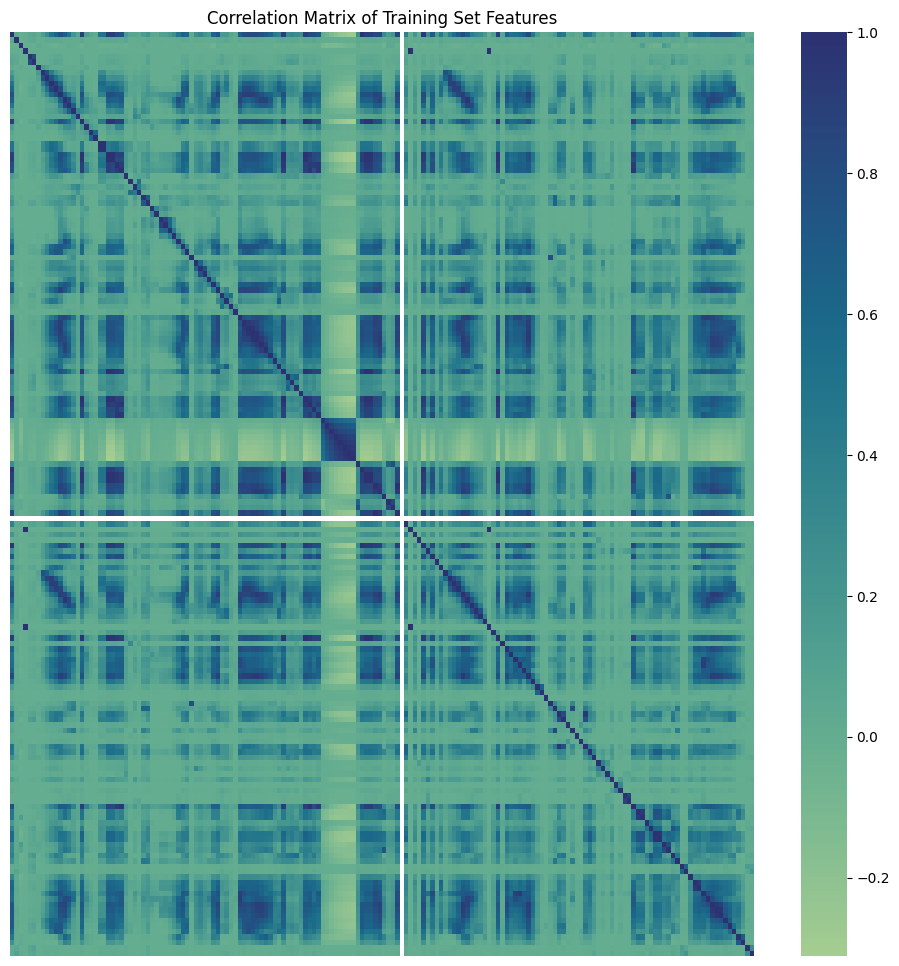

In [7]:
fit, axes = plt.subplots(figsize=(12, 12))
sb.heatmap(df_train_X_imputed.corr(), cmap = "crest", xticklabels=False, yticklabels=False, ax=axes)
plt.title("Correlation Matrix of Training Set Features")
plt.show()

#### (iv) Make scatter plots and box plots

In [8]:
sorted_index = np.argsort(coefficient_of_variation.iloc[2])[::-1][:math.floor(math.sqrt(170))]
selected_columns = df_train_X_imputed.columns[sorted_index]
print('Selected features:')
coefficient_of_variation[selected_columns][2:].T

Selected features:


cv
cs_009  235.277605
cf_000  184.233092
co_000  183.949017
ad_000  183.847620
dh_000  114.984991
dj_000  109.647285
ag_000   91.878565
as_000   86.416904
ay_009   83.786063
az_009   76.967978
ak_000   74.526688
au_000   68.160554
ch_000   58.268229

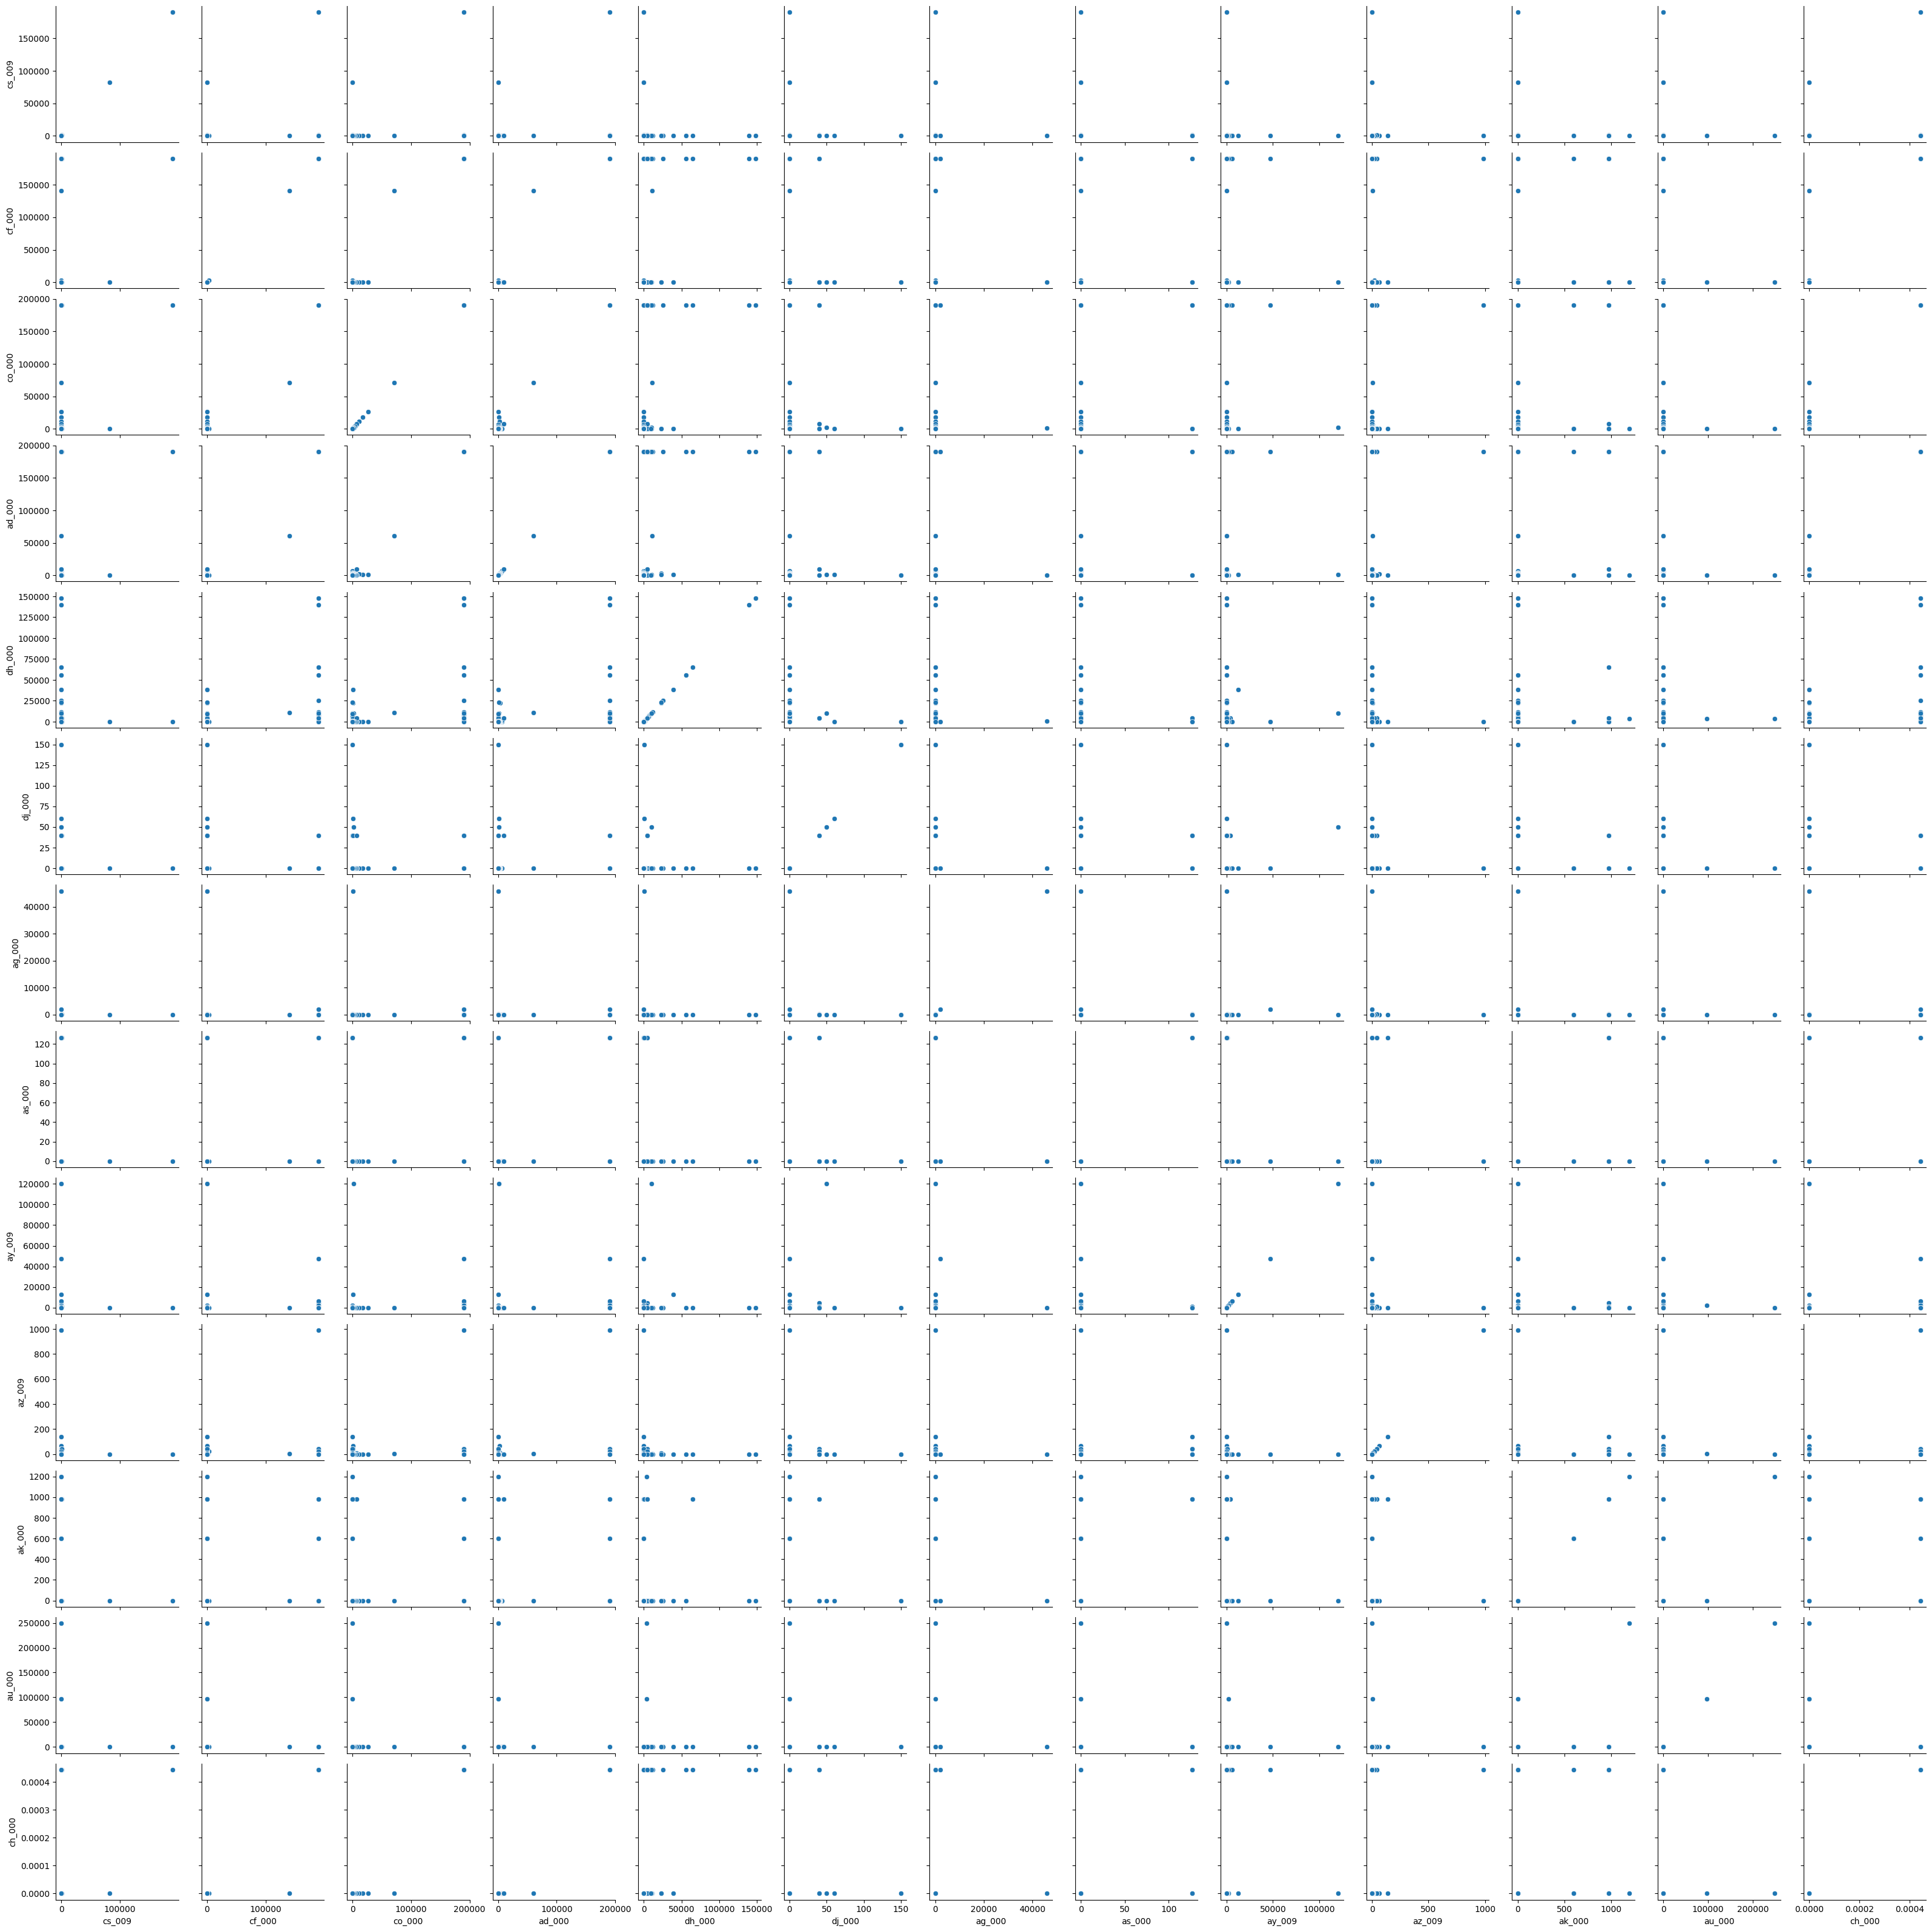

In [9]:
sns.pairplot(data = df_train_X_imputed[selected_columns].sample(1000), diag_kind = None)

[None]

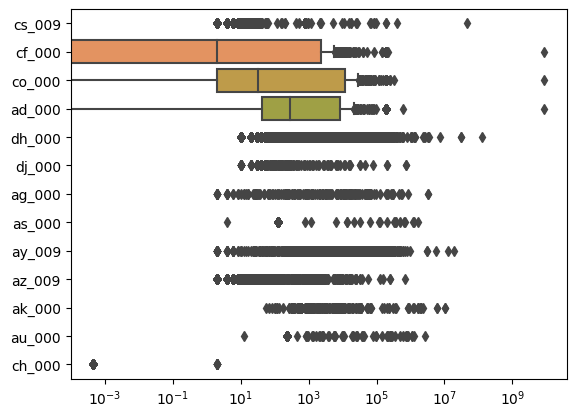

In [10]:
box = sns.boxplot(data = df_train_X_imputed[selected_columns], orient = 'h')
box.set(xscale = "log")

Conclusion:<br>
* From the scatterplots only we can't draw any conclusions.
* Since mean is used as the imputation strategy, any outlier can easily affect the datapoints.

#### (v) Is this data set imbalanced?

In [102]:
negative_values = df_train_Y.value_counts()[0]
positive_values = df_train_Y.value_counts()[1]

print("Total positive values in training plus testing sets are: ", positive_values)
print("Total negative values in training plus testing sets are: ", negative_values)

Total positive values in training plus testing sets are:  1000
Total negative values in training plus testing sets are:  59000


Conclusion:<br>
From the above values, we can clearly see that the number of positive samples are very less compared to the samples that have negative classes.<br>
By looking at the train/test data, we can see that the percetage of positive class is just $\frac{1000}{60000} = 1.667%$. Hence the data is <b>highly imbalanced</b>.

### (c) Train a random forest

In [13]:
def plot_roc_curve(y_train, y_train_prob, title):
    fig, axes = plt.subplots(figsize = (6, 4))
    axes.set_title(f"ROC curves for {title}")
    y_predicted = y_train_prob[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train, y_predicted)
    roc_auc = auc(fpr, tpr)
    axes.plot(fpr, tpr, label = f"ROC Curve Area: {round(roc_auc, 5)}")
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()

In [14]:
def model_summary(y_train, y_train_predicted, y_train_prob, title, is_xgboost = False):
    
    conf_matrix = confusion_matrix(y_train, y_train_predicted)
    print(f'Confusion Matrix: \n{conf_matrix}\n')
    
    # accuracy
    accuracy = round(accuracy_score(y_train, y_train_predicted), 5)
    print(f'Accuracy Score: {accuracy}')
    print(f'Error: {round(1 - accuracy, 5)}')
    
    if is_xgboost:
        roc = round(roc_auc_score(y_train, y_train_predicted), 5)
        print(f'ROC AUC Score: {roc}')
        
    plot_roc_curve(y_train, y_train_prob, title)
    
    data = {'conf_matrix': conf_matrix, 'accuracy': accuracy, 'error': round(1 - accuracy, 5)}
    if is_xgboost:
        data['roc'] = roc
    return data

In [15]:
def fit_rf(x_train, y_train, is_balanced = False):
    if not is_balanced:
        model = RandomForestClassifier(max_depth = 5, random_state = 60000, oob_score = True)
    else:
        model = RandomForestClassifier(max_depth = 5, random_state = 60000, 
                                          class_weight = 'balanced', oob_score = True)
    model.fit(x_train, y_train)
    return model

In [16]:
y_train = df_train_Y
model = fit_rf(df_train_X_imputed, y_train)
y_train_predicted = model.predict(df_train_X_imputed)
y_train_prob = model.predict_proba(df_train_X_imputed)
_ = model_summary(y_train, y_train_predicted, y_train_prob, "Training")

Confusion Matrix: 
[[58972    28]
 [  450   550]]

Accuracy Score: 0.99203
Error: 0.00797


In [17]:
y_test = df_test_Y
y_test_predicted = model.predict(df_test_X_imputed)
y_test_prob = model.predict_proba(df_test_X_imputed)
_ = model_summary(y_test, y_test_predicted, y_test_prob, "Testing")

Confusion Matrix: 
[[15612    13]
 [  180   195]]

Accuracy Score: 0.98794
Error: 0.01206


In [18]:
train_oob_error = round(1 - model.oob_score_, 5)
test_error = round(1 - accuracy_score(y_test, y_test_predicted), 5)
print("Train OOB Error: {}".format(train_oob_error))
print("Testing Error: {}".format(test_error))

Train OOB Error: 0.00937
Testing Error: 0.01206


#### Comparison:
* Test error is 28.71% more than the Train OOB error
* Due to less positive data points, model majorly learns negative class and so false negatives are higher in the test confusion matrix resulting in higher overall testing error compared to training error.

### (d) Research class imbalance in random forest

### Hypothesis: 

There are two ways to handle class imbalance: 

1. **RandomForestClassifier with class_weight = 'balanced:** Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.
2. **BalancedRandomForestClassifier:** A balanced random forest classifier. This model randomly undersamples each boostrap sample to negate imbalance effect.

In [19]:
model = fit_rf(df_train_X_imputed, y_train, is_balanced = True)
y_train_predicted = model.predict(df_train_X_imputed)
y_train_prob = model.predict_proba(df_train_X_imputed)
_ = model_summary(y_train, y_train_predicted, y_train_prob, "Training")

Confusion Matrix: 
[[56563  2437]
 [   31   969]]

Accuracy Score: 0.95887
Error: 0.04113


In [20]:
y_test_predicted = model.predict(df_test_X_imputed)
y_test_prob = model.predict_proba(df_test_X_imputed)
_ = model_summary(y_test, y_test_predicted, y_test_prob, "Testing")

Confusion Matrix: 
[[14992   633]
 [   15   360]]

Accuracy Score: 0.9595
Error: 0.0405


In [21]:
train_oob_error = round(1 - model.oob_score_, 5)
test_error = round(1 - accuracy_score(y_test, y_test_predicted), 5)
print("Train OOB Error: {}".format(train_oob_error))
print("Testing Error: {}".format(test_error))

Train OOB Error: 0.04245
Testing Error: 0.0405


Comparison:
* Here the testing error is 4.59% less than the OOB train error

### Findings: 

There are couple of observations here: 
1. In the case of imbalance data, the model makes good prediction over the negative class and since there are 59000 datapoints for the same, overall accuracy is very good. However, it has very poor predictions for positive class.
2. When the class is balanced, the model is significantly performing better for positive class. 

### (e) XGBoost and Model Trees

In [22]:
param_grid = {
    "reg_alpha": [0.01, 0.05, 0.07, 0.08, 0.1, 0.2]
}

In [23]:
def getXGBClassifier(x_train, y_train, param_grid):
    model = XGBClassifier(objective = 'binary:logistic', colsample_bytree = 0.3, 
                      learning_rate = 0.1, max_depth = 5, use_label_encoder = False)

    gridcv = GridSearchCV(  model, param_grid, n_jobs = -1, 
                            cv = KFold(n_splits = 5, shuffle = True, random_state = 69), 
                            scoring = "accuracy")

    gridcv.fit(x_train, y_train)
    best_alpha = gridcv.best_params_['reg_alpha']
    return gridcv, best_alpha

def test_classifier(x_train, y_train, x_test, y_test, best_alpha):
    model = XGBClassifier(objective = 'binary:logistic', reg_alpha = best_alpha, colsample_bytree = 0.3, 
                          learning_rate = 0.1, max_depth = 5, use_label_encoder = False)
    model.fit(x_train, y_train)
    
    y_train_predicted = model.predict(x_train)
    y_train_prob = model.predict_proba(x_train)

    y_test_predicted = model.predict(x_test)
    y_test_prob = model.predict_proba(x_test)

    stats = {}
    stats['train'] = model_summary(y_train.values, y_train_predicted, y_train_prob, "Training", is_xgboost = True)
    stats['test'] = model_summary(y_test, y_test_predicted, y_test_prob, "Testing", is_xgboost = True)
    return stats

In [24]:
ss = StandardScaler()
x_train_scaled = pd.DataFrame(ss.fit_transform(df_train_X_imputed), columns = df_train_X_imputed.columns)
x_test_scaled = pd.DataFrame(ss.fit_transform(df_test_X_imputed), columns = df_test_X_imputed.columns)

In [25]:
gridcv, best_alpha = getXGBClassifier(x_train_scaled, y_train, param_grid)
print('The best alpha: ', best_alpha)
print('Best CV training accuracy: ', round(gridcv.best_score_, 5))

The best alpha:  0.01
Best CV training accuracy:  0.99448


Confusion Matrix: 
[[58997     3]
 [  103   897]]

Accuracy Score: 0.99823
Error: 0.00177
ROC AUC Score: 0.94847


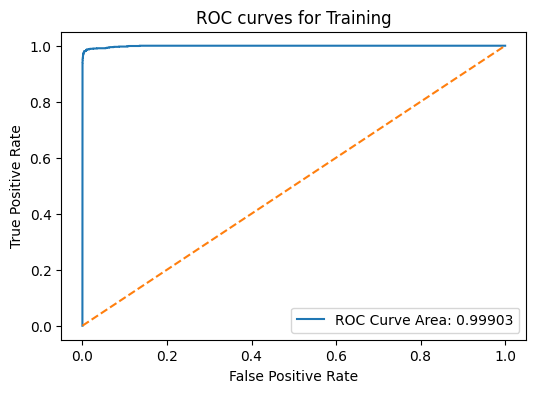

Confusion Matrix: 
[[15597    28]
 [  105   270]]

Accuracy Score: 0.99169
Error: 0.00831
ROC AUC Score: 0.8591


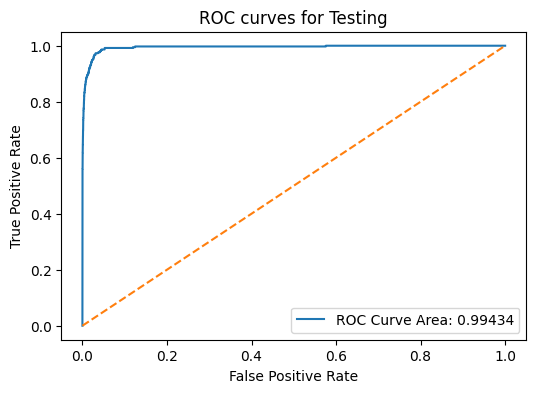

In [26]:
stats_1 = test_classifier(x_train_scaled, y_train, x_test_scaled, y_test, best_alpha)
stats_1['best_alpha'] = best_alpha

### (f) Use SMOTE to pre-process your data

In [27]:
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train_scaled, y_train)
print("Before SMOTE:")
print(y_train.value_counts())
print("\nAfter SMOTE:")
print(y_train_smote.value_counts())

Before SMOTE:
0    59000
1     1000
Name: class, dtype: int64

After SMOTE:
0    59000
1    59000
Name: class, dtype: int64


In [28]:
gridcv, best_alpha = getXGBClassifier(x_train_smote, y_train_smote, param_grid)
print('The best alpha: ', best_alpha)
print('Best CV training accuracy: ',round(gridcv.best_score_, 5))

The best alpha:  0.1
Best CV training accuracy:  0.9944


Confusion Matrix: 
[[58644   356]
 [   55 58945]]

Accuracy Score: 0.99652
Error: 0.00348
ROC AUC Score: 0.99652


Confusion Matrix: 
[[13178  2447]
 [   10   365]]

Accuracy Score: 0.84644
Error: 0.15356
ROC AUC Score: 0.90836


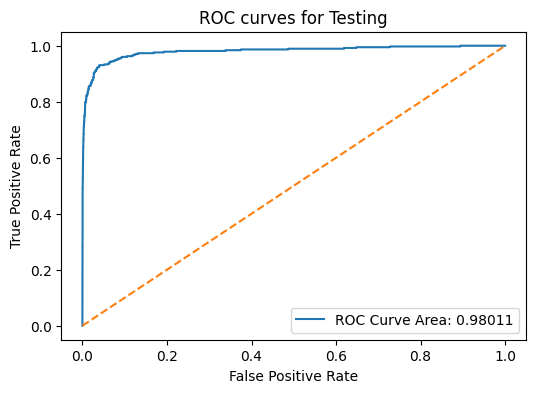

In [29]:
stats_2 = test_classifier(x_train_smote, y_train_smote, x_test_scaled, y_test, best_alpha)
stats_2['best_alpha'] = best_alpha

In [30]:
arr = [[stats_1['train']['error'], stats_1['train']['accuracy'], stats_1['train']['roc'], 
       stats_1['test']['error'], stats_1['test']['accuracy'], stats_1['test']['roc']], 
       [stats_2['train']['error'], stats_2['train']['accuracy'], stats_2['train']['roc'], 
       stats_2['test']['error'], stats_2['test']['accuracy'], stats_2['test']['roc']]]

df = pd.DataFrame(arr, columns = ['Train Error', 'Train Accuracy', 'Train ROC', 'Test Error', 'Test Accuracy', 'Test ROC'])
df.index = ['Without SMOTE', 'with SMOTE']
df

Train Error  Train Accuracy  Train ROC  Test Error  \
Without SMOTE      0.00177         0.99823    0.94847     0.00831   
with SMOTE         0.00348         0.99652    0.99652     0.15356   

               Test Accuracy  Test ROC  
Without SMOTE        0.99169   0.85910  
with SMOTE           0.84644   0.90836

## 2. ISLR 6.6.3

(a) **Steadily Decrease:** As we increase s value from 0 to inf, we are relaxing the constraints on $\beta$'s, hence we are going towards overfiting from underfitting. Hence training RSS would steadily decrease. 

(b) **Decrease Initially and then eventually starts increasing in a new shape.** Since we are moving from underfit model to overfit model, testing RSS will first go down and then increase for overfit models. 

(c) **Steadily Increases:** $\beta$ is almost zero in the beginning which would mean that there is almost no variance in the beginning. Hence variance will go up as we move from s = 0 to s = inf. 

(d) **Steadily Decrease:** Since the variance is increasing, the bias will decrease. This is the basics of bias-variance trade-off.

(e) **Irreducible error** is "act of god" and not in any ML model's control to change. Hence it will remain constant.

## 3. ISLR 6.6.5

### Part (a)

For ridge regression, we have

$
X =
  \begin{bmatrix}
    x_{11} x_{12} \\
    x_{21} x_{22}
  \end{bmatrix}
$

After equiting $x_{11} = x_{12} $ and $x_{21} == x_{22}$, we have,

$
X =
  \begin{bmatrix}
    x_{11} x_{11} \\
    x_{22} x_{22}
  \end{bmatrix}
$

For ridge coeeficient estimates, all values that minimizing, 

$\sum_{1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p}\beta_jx_{ij})^2 + \lambda \sum_{j=1}^{p}\beta_j^2$

Since key for ridge regression is to select $\lambda$ such that $\beta_2$ is minimized, 

$\sum_{1}^{2} (y_i - \beta_0 - \sum_{j=1}^{2}\beta_jx_{ij})^2 + \lambda \sum_{j=1}^{2}\beta_j^2$

$(y_1 - \beta_0 - \beta_1x_{11} - \beta_2x_{12})^2 + (y_2 - \beta_0 - \beta_1x_{21} - \beta_2x_{22})^2 + \lambda(\beta_1^2 + \beta_2^2)$, 

Given that $x_{11} = x_{12} $ and $x_{21} = x_{22}$ and $\hat{\beta_0}$ = 0, 

Final problem in this settings would be,

$(y_1 - x_{11} ( \hat{\beta_1} + \hat{\beta_2}))^2 + (y_2 - x_{22}( \hat{\beta_1} + \hat{\beta_2}))^2 + \lambda(\hat{\beta_1}^2 + \hat{\beta_2}^2)$

### Part (b)

Let $f(\hat{\beta_1}, \hat{\beta_2}) = (y_1 - x_{11} ( \hat{\beta_1} + \hat{\beta_2}))^2 + (y_2 - x_{22}( \hat{\beta_1} + \hat{\beta_2}))^2 + \lambda(\hat{\beta_1}^2 + \hat{\beta_2}^2)$

Since $x_{11} = x_{22} $, 

Let $f(\hat{\beta_1}, \hat{\beta_2}) = 2(y_1 - x_{11} ( \hat{\beta_1} + \hat{\beta_2}))^2 + \lambda(\hat{\beta_1}^2 + \hat{\beta_2}^2)$

Minimizing the equation be taking partial derivation, 

$\frac{{\partial f}}{{\partial \hat{\beta}}} = 4\beta_1x_{11}^2 - 4y_1x_{11} + 4x_{11}^2\beta_2^2 + 2\lambda\hat{\beta_1} = 0$

$\hat{\beta_1}[4x_{11}^2 + 2\lambda] - 4y_1x_{11} + 4x_{11}^2\hat{\beta_2} = 0$

$\hat{\beta_1}[2x_{11}^2 + \lambda] - 2y_1x_{11} + 2x_{11}^2\hat{\beta_2} = 0$

Hence, 

$\hat{\beta_1} = \frac{2y_1x_{11} - 2x_{11}^2\hat{\beta_2}}{\lambda + 2x_{11}^2}$

$\hat{\beta_2} = \frac{2y_1x_{11} - 2x_{11}^2\hat{\beta_1}}{\lambda + 2x_{11}^2}$

By eliminating the terms in two equations, we can obtain that:
$\hat{\beta_1} = \hat{\beta_2}$

### Part (c)

Substituting the $\beta s$ in the same equation as (a),

$2(y_1 - \hat{\beta_1}x_{11} - \hat{\beta_2}x_{11})^2 + \lambda(\left|\hat{\beta_1}\right| + \left|{\hat{\beta_2}}\right|)$

### Pard (d)

To minimize the above equation, taking derivate again as shown in part (b), 

$\frac{{\partial f}}{{\partial \hat{\beta}}}$ = 0

$4x_{11}[y_1 - x_{11}(\hat{\beta_1} + \hat{\beta_2})] = \pm \lambda$

The sign of the right hand side depends on the value of the $\beta$. This is the optimization problem in LASSO and can have many more solutions. 

## 4. ISLR 8.4.5

1. **Majority Polling:** When overall probability is greater than 0.5, the classification will be true and else otherwise. Out of 10 samples, 4 samples have probability < 0.5 and 6 samples have probability >= 0.5. Since positive/True class is in majority, classification would be **red**.

2. **Average Probability:** Mean for given probabilities = 0.45 hence the classification would be **green**.

## 5. ISLR 9.7.3

In [31]:
data = pd.DataFrame({'X1': [3, 2, 4, 1, 2, 4, 4], 
                   'X2':[4, 2, 4, 4, 1, 3, 1], 
                   'Y':['red', 'red', 'red', 'red', 'blue', 'blue', 'blue']})

data['Y'].replace({'blue': 0, 'red': 1}, inplace = True)
x_train, y_train = data.drop(['Y'], axis = 1), data['Y']
model = svm.SVC(kernel = 'linear', C = 1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_train)

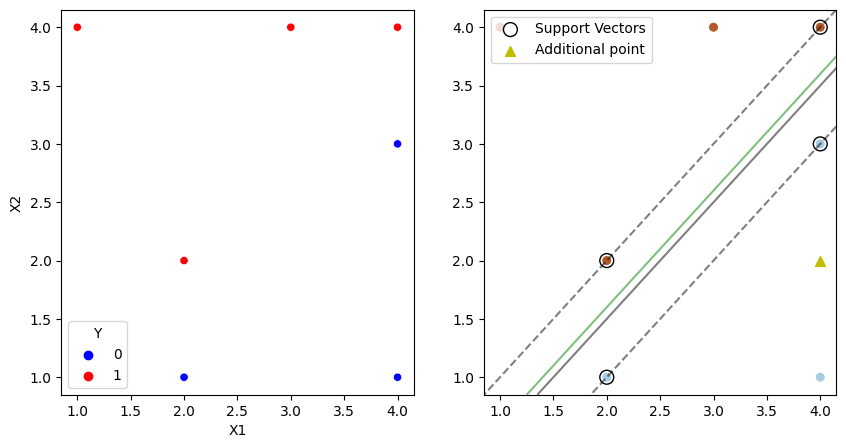

[0.99970703] [[-1.99941406  1.99941406]]


In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(data = data, x = "X1", y = "X2", hue = "Y", palette = ['blue', 'red'], ax = ax[0])

ax[1].scatter(data.iloc[:, 0], data.iloc[:, 1], 
              c = data.iloc[:, -1], s = 30, cmap = plt.cm.Paired)

xlim, ylim = ax[1].get_xlim(), ax[1].get_ylim()
y_axis, x_axis = np.meshgrid(np.linspace(xlim[0], xlim[1], 30), np.linspace(xlim[0], xlim[1], 30))
xy_axis = np.vstack([x_axis.ravel(), y_axis.ravel()]).T
z_axis = model.decision_function(xy_axis).reshape(x_axis.shape)


ax[1].scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s = 100,
           linewidth = 1, facecolors = 'none', edgecolors='k', label = "Support Vectors")
ax[1].scatter([4.0], [2.0], color = 'y', marker = '^', s = 50, label = "Additional point")
ax[1].contour(x_axis, y_axis, z_axis - 0.2, colors = 'g', levels = [0], alpha = 0.5,
           linestyles=['-'])
ax[1].contour(x_axis, y_axis, z_axis, colors = 'k', levels = [-1, 0, 1], alpha = 0.5,
           linestyles=['--', '-', '--'], label = "Decision Boundary")
ax[1].legend(loc='upper left')

plt.show()
print(model.intercept_, model.coef_)

(a) Visulisation is shown above

(b) **The solid black** line is a hyperplane

(c) $\beta_0 = 1, \beta_1 = -1, \beta_2 = 2$ 

$\beta_0 + \beta_1 X_1 + \beta_2 X_2 >= 0$ implies red, otherwise blue

(d) **The dashed line** indicates the maximal margin.

(e) Support vectors are shown in **circled form**. 

(f) The seventh point is far away from the maximal margin hyperplane. If it is on the edge of the decision boundary, it will have effects, but it does not.

(g) **Solid green line** is not an optimal hyperplane. 

(h) The new point marked as a yellow triangle which makes it **not linearly separable**.